#### Load Library

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import gc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

import missingno as msno
import warnings

warnings.filterwarnings(action='ignore')


from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, train_test_split

from itertools import product

In [2]:
# plot에서 한글이 깨지지 않게 하기 위해 설정
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (8,3)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["font.size"] = 10

In [3]:
# 데이터 타입 변경을 통해 메모리 사용량 감소
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

#### Load Data and pickle file 

In [4]:
train = pd.read_csv("201901-202003.csv")
# test = pd.read_csv()
sub = pd.read_csv("submission.csv")


with open('age_rate_dict.pickle', 'rb') as f:
    age_rate_dict = pickle.load(f)
    
with open('sex_rate_dict.pickle', 'rb') as f:
    sex_rate_dict = pickle.load(f)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24697792 entries, 0 to 24697791
Data columns (total 12 columns):
REG_YYMM        int64
CARD_SIDO_NM    object
CARD_CCG_NM     object
STD_CLSS_NM     object
HOM_SIDO_NM     object
HOM_CCG_NM      object
AGE             object
SEX_CTGO_CD     int64
FLC             int64
CSTMR_CNT       int64
AMT             int64
CNT             int64
dtypes: int64(6), object(6)
memory usage: 2.2+ GB


In [6]:
# train.head(10)

In [5]:
group_col = ["REG_YYMM", "CARD_SIDO_NM", "STD_CLSS_NM"]

#### 변수 설명

In [8]:
# REG_YYKM : 년월
# CARD_SIDO_MM : 카드이용지역_시도
# CARD_CCG_NM : 카드이용지역_시군구 (가맹점 주소 기준)
# STD_CLSS_NM : 업종명
# HOM_SIDO_NM : 거주지역_시도 (고객 집주소 기준)
# HOM_CCG_NM : 거주지역_시군구 (고객 집주소 기준)
# AGE : 연령대
# SEX_CTGO_CD : 성별 (1: 남성, 2: 여성)
# FLC : 가구생애주기 (1: 1인가구, 2: 영유아자녀가구, 3: 중고생자녀가구, 4: 성인자녀가구, 5: 노년가구)
# CSTMR_CNT : 이용고객수 (명)
# AMT : 이용금액 (원)
# CNT : 이용건수 (건)

#### 결측치 확인

In [9]:
train.isnull().sum() # CARD_CCG_NM, HOM_CCG_NM 에서 결측치 존재

REG_YYMM             0
CARD_SIDO_NM         0
CARD_CCG_NM      87213
STD_CLSS_NM          0
HOM_SIDO_NM          0
HOM_CCG_NM      147787
AGE                  0
SEX_CTGO_CD          0
FLC                  0
CSTMR_CNT            0
AMT                  0
CNT                  0
dtype: int64

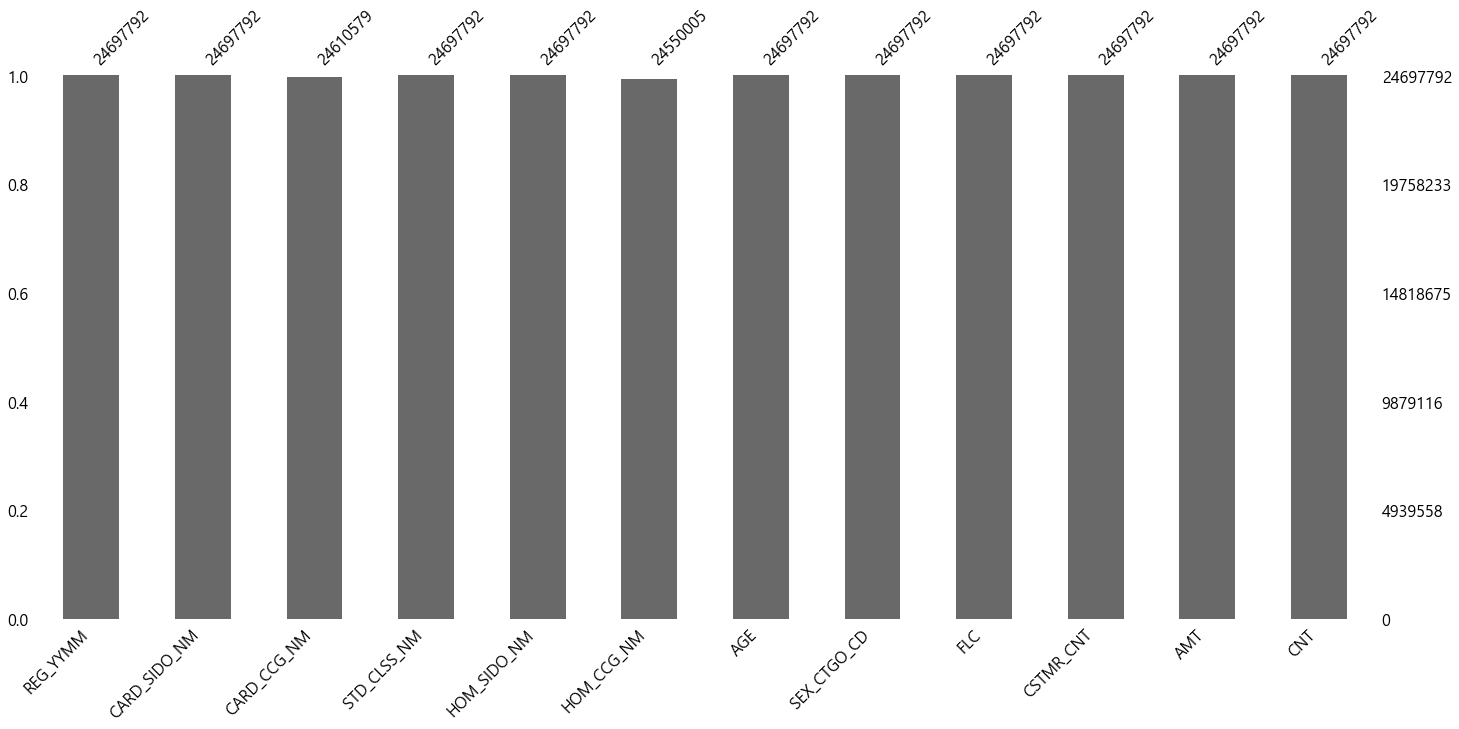

In [5]:
msno.bar(train) 

In [6]:
#결측치 처리
train.CARD_CCG_NM.isnull().sum() # 87213
train[train.CARD_CCG_NM.isnull()].CARD_SIDO_NM.unique() # array(['세종'], dtype=object)

train.fillna("세종시", inplace=True)

#### Label Encoding

In [7]:
# datatype이 object인 columns
obj_cols = list(train.select_dtypes(include="O").columns)

# Label Encoding
for col in obj_cols:
    globals()[f'le_{col}'] = LabelEncoder()
    globals()[f'le_{col}'].fit(train[col])

    train[col] = globals()[f'le_{col}'].transform(train[col])

In [8]:
# 추후 inverser transform을 하기 위해 각 encoder를 list에 저장
le_list = [var for var in dir() if var.startswith("le_")]
le_list

['le_AGE',
 'le_CARD_CCG_NM',
 'le_CARD_SIDO_NM',
 'le_HOM_CCG_NM',
 'le_HOM_SIDO_NM',
 'le_STD_CLSS_NM']

In [9]:
le_CARD_SIDO_NM.transform(['제주']) # 14 

array([14], dtype=int64)

In [9]:
train = reduce_mem_usage(train)

Mem. usage decreased to 706.61 Mb (58.3% reduction)


In [9]:
train.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,0,3,0,0,3,1,1,1,4,311200,4
1,201901,0,3,0,0,3,2,1,2,7,1374500,8
2,201901,0,3,0,0,3,2,2,2,6,818700,6
3,201901,0,3,0,0,3,3,1,3,4,1717000,5
4,201901,0,3,0,0,3,3,1,4,3,1047300,3


### EDA

In [14]:
train["REG_YYMM"] = pd.to_datetime(train.REG_YYMM.apply(lambda x:str(x)), format="%Y%m")
train["TIME"] = train.REG_YYMM.apply(lambda x : (x.year, x.month)) # EDA시 x축에 사용하기 위해 만듦. plot을 그리지 않을경우 필요없음

In [18]:
data = train.groupby(["TIME"]).sum()[["CSTMR_CNT", "CNT", "AMT"]].reset_index()

#tuple형태로 plot의 xticks에 들어갈때 twinx에서 오류가 생기는 것 같음.
data["TIME"] = data.TIME.apply(lambda x : str(x[0]) + "-" + str(x[1]))

20

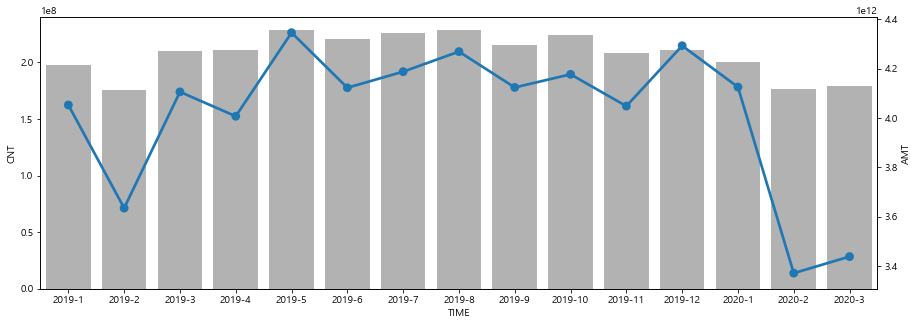

In [14]:
fig, ax = plt.subplots(figsize = (15,5))

sns.barplot( data = data, x = 'TIME', y = "CNT", ax = ax, color = "grey", alpha = 0.6)

ax_t = ax.twinx()
ax_t = sns.pointplot( data = data, x = "TIME", y = "AMT")

gc.collect()

* CNT(고객수)와 AMT가 상관성이 높아보이지만 20년 2월,3월의 경우 CNT의 낙폭에 비해 AMT의 낙폭이 너무 차이가 많음
* 좀 더 세부적으로 나눠볼 필요가 있을듯함

#### 시외/시내 결제

In [24]:
# 시외소비 여부

train["Consume_OOT"] = 1
train.loc[(train.CARD_CCG_NM == train.HOM_CCG_NM) & (train.CARD_SIDO_NM == train.HOM_SIDO_NM), "Consume_OOT"] = 0

In [16]:
train.Consume_OOT.value_counts()

1    22891901
0     1805891
Name: Consume_OOT, dtype: int64

90

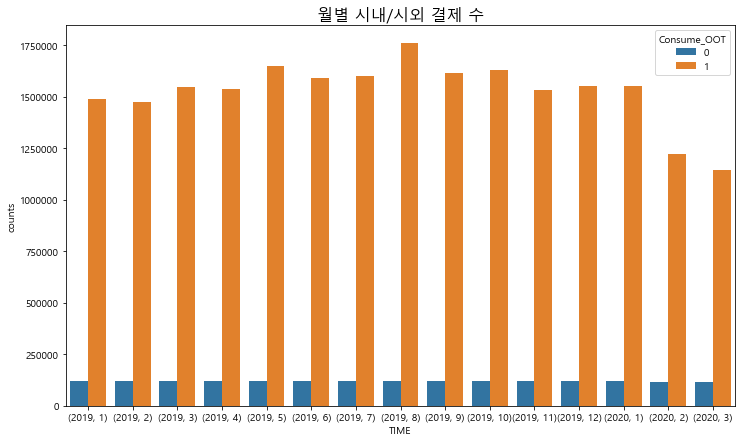

In [19]:
plt.figure(figsize = (12,7))
sns.barplot(
    data = train.groupby(["TIME","Consume_OOT"]).size().reset_index(name = "counts"),
    x = 'TIME',
    y = 'counts',
    hue = 'Consume_OOT'
)

plt.title("월별 시내/시외 결제 수", fontsize = 16 )

gc.collect()

In [20]:
tmp_df = train.groupby(["TIME","Consume_OOT"]).size().reset_index(name = "counts")

In [21]:
compare_df = pd.crosstab(tmp_df.TIME, tmp_df.Consume_OOT, values=tmp_df.counts, aggfunc='sum', normalize="index").reset_index()

del tmp_df

In [22]:
compare_df["TIME"] = compare_df.TIME.apply(lambda x : str(x[0]) + "-" + str(x[1]))

In [23]:
compare_df

Consume_OOT,TIME,0,1
0,2019-1,0.074625,0.925375
1,2019-2,0.074653,0.925347
2,2019-3,0.072205,0.927795
3,2019-4,0.072583,0.927417
4,2019-5,0.068794,0.931206
5,2019-6,0.070595,0.929405
6,2019-7,0.070345,0.929655
7,2019-8,0.064540,0.935460
8,2019-9,0.070206,0.929794
9,2019-10,0.069263,0.930737


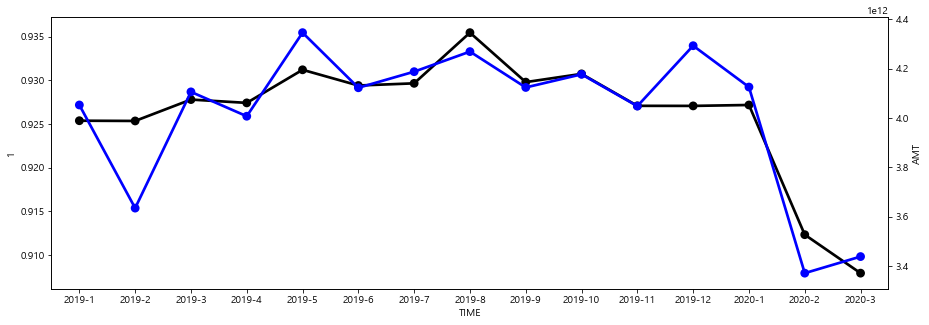

In [24]:
fig, ax = plt.subplots(figsize=(15,5))

sns.pointplot( data = compare_df, x = "TIME", y = 1, color = 'k')

ax_t = ax.twinx()
ax_t = sns.pointplot( data = data, x = "TIME", y = "AMT", color = 'blue')

In [76]:
tmp_df = train.groupby(["TIME","Consume_OOT"]).size().reset_index(name = "counts").pivot("TIME", "Consume_OOT", "counts")

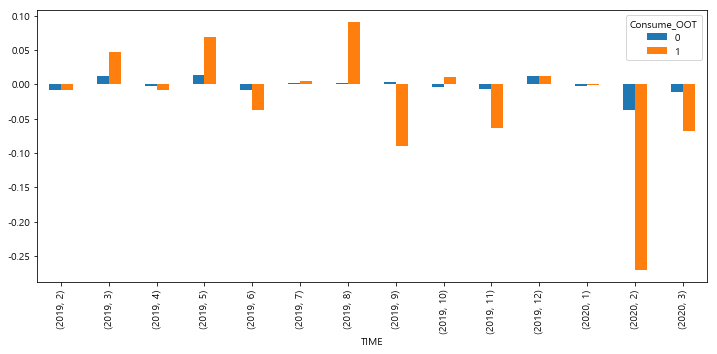

In [77]:
# 전달 대비 카드사용량 변동률
((tmp_df - tmp_df.shift().fillna(0)) / tmp_df).iloc[1:,:].plot(kind='bar', figsize=(12,5))

In [152]:
###

In [159]:
train.groupby(["CARD_SIDO_NM", "STD_CLSS_NM", "Consume_OOT"])["AMT"].mean().reset_index()

,CARD_SIDO_NM,STD_CLSS_NM,Consume_OOT,AMT
0,강원,건강보조식품 소매업,False,1.400028e+06
1,강원,건강보조식품 소매업,True,2.315739e+05
2,강원,골프장 운영업,False,2.971101e+06
3,강원,골프장 운영업,True,1.525552e+06
4,강원,과실 및 채소 소매업,False,2.772122e+06
...,...,...,...,...
1245,충북,호텔업,True,2.618859e+05
1246,충북,화장품 및 방향제 소매업,False,1.847392e+06
1247,충북,화장품 및 방향제 소매업,True,6.222528e+05
1248,충북,휴양콘도 운영업,False,4.981869e+05


#### AGE_RATE groupby CARD_SIDO_NM and STD_CLSS_NM

In [81]:
train.groupby(group_col+ ["AGE"])['CSTMR_CNT'].sum().reset_index()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AGE,CSTMR_CNT
0,2019-01-01,0,0,1,4
1,2019-01-01,0,0,2,133
2,2019-01-01,0,0,3,171
3,2019-01-01,0,0,4,395
4,2019-01-01,0,0,5,298
...,...,...,...,...,...
58670,2020-03-01,16,40,1,7
58671,2020-03-01,16,40,2,44
58672,2020-03-01,16,40,3,26
58673,2020-03-01,16,40,4,23


In [ ]:
idx_len = train.groupby(group_col+ ["AGE"])['CSTMR_CNT'].sum().reset_index().groupby(group_col).size().values

tmp_df1 = train.groupby(group_col+ ["AGE"])['CSTMR_CNT'].sum().reset_index()
tmp_df2 = train.groupby(group_col)['CSTMR_CNT'].sum().reset_index()

In [ ]:
sum(idx_len) == tmp_df1.shape[0]

In [17]:
tmp_df1['CSTMR_AGE_RATE'] = np.divide(tmp_df1.CSTMR_CNT, [tmp_df2.CSTMR_CNT[i] for i,k in enumerate(idx_len) for _ in range(k)])

In [31]:
tmp_df1.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AGE,CSTMR_CNT,CSTMR_AGE_RATE
0,2019-01-01,0,0,1,4,0.003704
1,2019-01-01,0,0,2,133,0.123148
2,2019-01-01,0,0,3,171,0.158333
3,2019-01-01,0,0,4,395,0.365741
4,2019-01-01,0,0,5,298,0.275926


In [32]:
"""
AGE_RATE = tmp_df1.groupby(["CARD_SIDO_NM", "STD_CLSS_NM", "AGE"]).mean()["CSTMR_AGE_RATE"].reset_index()
AGE_RATE_dict = AGE_RATE.set_index(['CARD_SIDO_NM', 'STD_CLSS_NM','AGE']).to_dict()
"""

'\nAGE_RATE = tmp_df1.groupby(["CARD_SIDO_NM", "STD_CLSS_NM", "AGE"]).mean()["CSTMR_AGE_RATE"].reset_index()\nAGE_RATE_dict = AGE_RATE.set_index([\'CARD_SIDO_NM\', \'STD_CLSS_NM\',\'AGE\']).to_dict()\n'

In [21]:
tmp_df1.drop("CSTMR_CNT", axis=1, inplace=True)
age_rate_dict = tmp_df1.set_index(group_col + ["AGE"]).to_dict().get('CSTMR_AGE_RATE')

In [13]:
"""
with open('age_rate_dict.pickle', "wb") as f:
    pickle.dump(age_rate_dict, f, protocol = pickle.HIGHEST_PROTOCOL)
"""

#### 업종별 결제금액

In [14]:
std_class = list(train.STD_CLSS_NM.unique())

In [27]:
def AMT_FLOW(CLSS_NM_LIST):
    for clss_nm in CLSS_NM_LIST:
        plt.figure(figsize = (12,4))
        
        tmp_df = train.loc[train.STD_CLSS_NM == std_class[clss_nm]].\
                        groupby(group_col).\
                        agg({'CSTMR_CNT' : 'sum', 'AMT' : 'sum'}).\
                        reset_index().\
                        drop('STD_CLSS_NM', axis=1)
    
        sns.lineplot(
            x = tmp_df.REG_YYMM, y = np.log(tmp_df.AMT),
            hue = tmp_df.CARD_SIDO_NM
        )

        plt.show()
    gc.collect()

c:\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


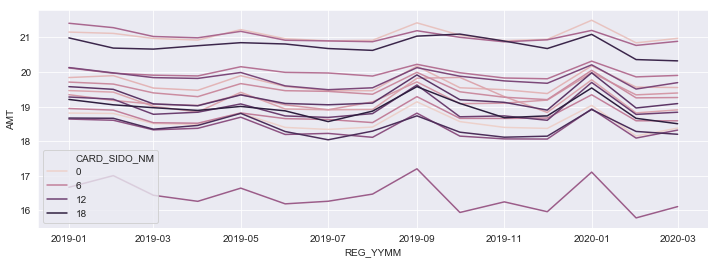

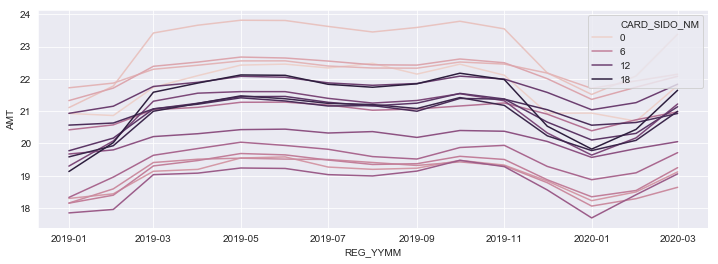

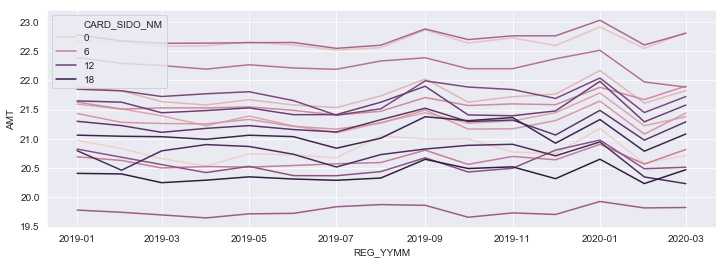

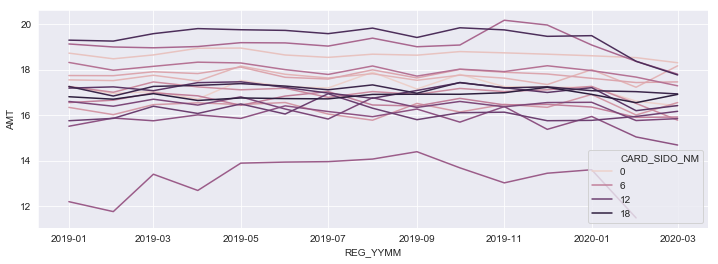

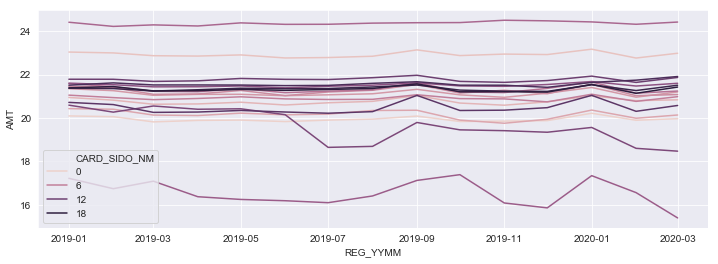

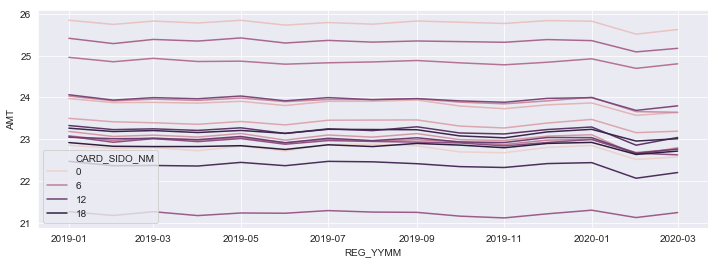

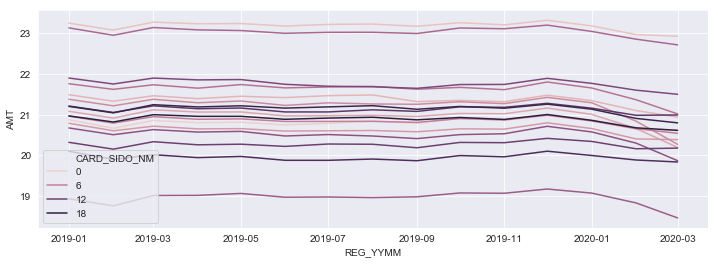

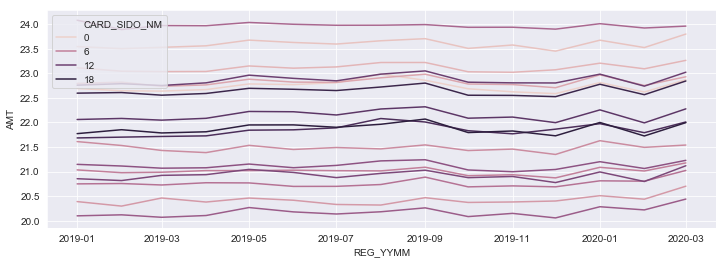

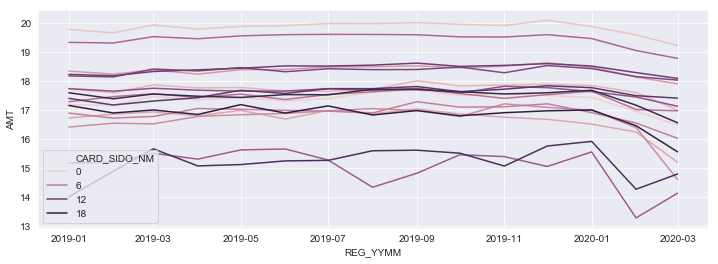

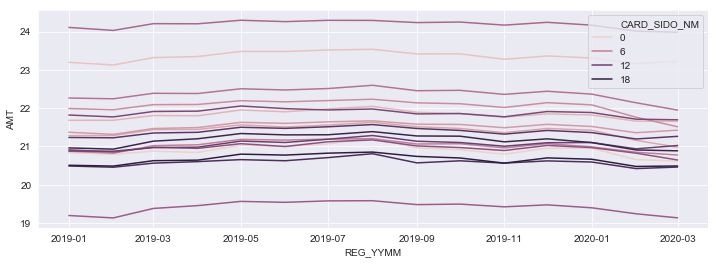

In [75]:
AMT_FLOW(std_class[:10])

* 업종별로 시기(월)별 소비자수의 패턴이 다름

In [122]:
le_CARD_SIDO_NM.inverse_transform([8])

array(['서울'], dtype=object)

#### 가구 생애 ( FLC ) 별 소비 

* FLC : 가구생애주기 (1: 1인가구, 2: 영유아자녀가구, 3: 중고생자녀가구, 4: 성인자녀가구, 5: 노년가구)

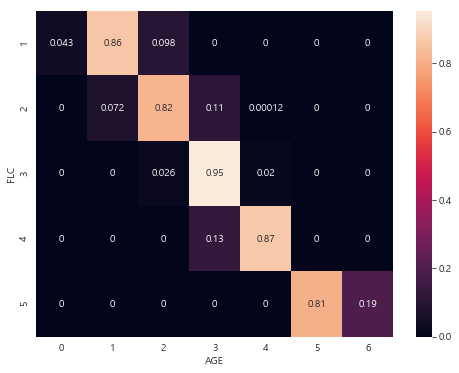

In [94]:
plt.figure(figsize = (8, 6))
sns.heatmap(pd.crosstab(train.FLC, train.AGE, values=train.CSTMR_CNT, aggfunc = 'sum', normalize="index").fillna(0), annot = True)

나이대와 가구생애를 1:1 매칭하여 생각해도 될듯
* 20대 : 1인가구
* 30대 : 영유아자녀가구
* 40대 : 중고생자녀가구
* 50대 : 성인자녀가구
* 60,70대 : 노년가구

In [ ]:
tmp_data = train.groupby(["FLC","STD_CLSS_NM"])["CSTMR_CNT"].sum().reset_index()

In [118]:
tmp_data['STD_CLSS_NM'] = tmp_data.STD_CLSS_NM.apply(lambda x : le_STD_CLSS_NM.inverse_transform([x])[0])

In [119]:
tmp_pivot = pd.crosstab(tmp_data.FLC, tmp_data.STD_CLSS_NM, tmp_data.CSTMR_CNT, aggfunc='sum', normalize='columns').T

In [128]:
tmp_pivot = pd.DataFrame(tmp_pivot.to_records())

In [131]:
flat_tmp_pivot = tmp_pivot.melt(id_vars=['STD_CLSS_NM'])

In [1]:
"""plt.figure(figsize = (6, 48))
sns.barplot(
    data = flat_tmp_pivot,
    y = 'STD_CLSS_NM',
    x = 'value',
    hue = 'variable'
)"""

"plt.figure(figsize = (6, 48))\nsns.barplot(\n    data = flat_tmp_pivot,\n    y = 'STD_CLSS_NM',\n    x = 'value',\n    hue = 'variable'\n)"

In [129]:
tmp_pivot

,STD_CLSS_NM,1,2,3,4,5
0,건강보조식품 소매업,0.026064,0.158832,0.128861,0.307167,0.379075
1,골프장 운영업,0.005289,0.044631,0.178804,0.491222,0.280054
2,과실 및 채소 소매업,0.062570,0.160073,0.180682,0.314167,0.282509
3,관광 민예품 및 선물용품 소매업,0.309385,0.198068,0.171536,0.204503,0.116507
4,그외 기타 분류안된 오락관련 서비스업,0.275835,0.309221,0.352941,0.062003,0.000000
5,그외 기타 스포츠시설 운영업,0.143785,0.258863,0.456856,0.123668,0.016827
6,그외 기타 종합 소매업,0.106944,0.229850,0.183204,0.273643,0.206359
7,기타 대형 종합 소매업,0.115831,0.244822,0.213045,0.259998,0.166304
8,기타 수상오락 서비스업,0.264548,0.225140,0.303715,0.178798,0.027800
9,기타 외국식 음식점업,0.152943,0.236399,0.195632,0.271217,0.143810


#### 시외소비층과 시내소비층 

In [153]:
pd.crosstab(
    train[["Consume_OOT", "AGE", "FLC", "CSTMR_CNT"]].groupby(["Consume_OOT", "AGE"]).sum().reset_index()['Consume_OOT'],
    train[["Consume_OOT", "AGE", "FLC", "CSTMR_CNT"]].groupby(["Consume_OOT", "AGE"]).sum().reset_index()['AGE'],
    train[["Consume_OOT", "AGE", "FLC", "CSTMR_CNT"]].groupby(["Consume_OOT", "AGE"]).sum().reset_index()['CSTMR_CNT'],
    aggfunc = 'sum',
    normalize = 'columns'
)

AGE,0,1,2,3,4,5,6
Consume_OOT,,,,,,,
0,0.710603,0.405681,0.457608,0.558109,0.542211,0.574177,0.661427
1,0.289397,0.594319,0.542392,0.441891,0.457789,0.425823,0.338573


* 10대와 70대는 같은 도시에서 소비를 하는 경향이 큼 (**시내소비 성향이 큼**)
* 20~30대의 경우 **시외소비** 의 비율이 **시내소비**에 비해 조금 높은 편
* 40~50대의 경우 **시내소비** 의 비율이 **시외소비**에 비해 조금 높은 편

In [154]:
pd.crosstab(
    train[["Consume_OOT", "AGE", "FLC", "CSTMR_CNT"]].groupby(["Consume_OOT", "FLC"]).sum().reset_index()['Consume_OOT'],
    train[["Consume_OOT", "AGE", "FLC", "CSTMR_CNT"]].groupby(["Consume_OOT", "FLC"]).sum().reset_index()['FLC'],
    train[["Consume_OOT", "AGE", "FLC", "CSTMR_CNT"]].groupby(["Consume_OOT", "FLC"]).sum().reset_index()['CSTMR_CNT'],
    aggfunc = 'sum',
    normalize = 'columns'
)

FLC,1,2,3,4,5
Consume_OOT,,,,,
0,0.415906,0.469044,0.547207,0.552961,0.591103
1,0.584094,0.530956,0.452793,0.447039,0.408897


#### 성별 

In [159]:
tmp_SEX_CTGO_CD = train.groupby(["STD_CLSS_NM","SEX_CTGO_CD", "AGE"])['CSTMR_CNT'].sum().reset_index()

업종 - 성별 / 나이대 별 비율 

In [167]:
tmp_SEX_CTGO_CD['STD_CLSS_NM'] = le_STD_CLSS_NM.inverse_transform(tmp_SEX_CTGO_CD['STD_CLSS_NM'])

In [171]:
pd.crosstab(
    tmp_SEX_CTGO_CD.STD_CLSS_NM,
    tmp_SEX_CTGO_CD.SEX_CTGO_CD,
    tmp_SEX_CTGO_CD.CSTMR_CNT, aggfunc = sum, normalize='index'
).sort_values(by = 2, ascending = False).head(10)

SEX_CTGO_CD,1,2
STD_CLSS_NM,,
화장품 및 방향제 소매업,0.228295,0.771705
건강보조식품 소매업,0.403305,0.596695
빵 및 과자류 소매업,0.408198,0.591802
관광 민예품 및 선물용품 소매업,0.422275,0.577725
과실 및 채소 소매업,0.440827,0.559173
육류 소매업,0.454257,0.545743
비알콜 음료점업,0.457691,0.542309
서양식 음식점업,0.458080,0.541920
기타 대형 종합 소매업,0.468893,0.531107


In [172]:
idx_len = train.groupby(group_col+ ["SEX_CTGO_CD"])['CSTMR_CNT'].sum().reset_index().groupby(group_col).size().values

tmp_df1 = train.groupby(group_col+ ["SEX_CTGO_CD"])['CSTMR_CNT'].sum().reset_index()
tmp_df2 = train.groupby(group_col)['CSTMR_CNT'].sum().reset_index()

sum(idx_len) == tmp_df1.shape[0]

tmp_df1['CSTMR_SEX_CTGO_CD_RATE'] = np.divide(tmp_df1.CSTMR_CNT, [tmp_df2.CSTMR_CNT[i] for i,k in enumerate(idx_len) for _ in range(k)])

In [174]:
tmp_df1.drop("CSTMR_CNT", axis=1, inplace=True)

In [180]:
sex_rate_dict = tmp_df1.set_index(group_col + ["SEX_CTGO_CD"]).to_dict().get('CSTMR_SEX_CTGO_CD_RATE')

In [188]:
"""
with open('sex_rate_dict.pickle', "wb") as f:
    pickle.dump(sex_rate_dict, f, protocol = pickle.HIGHEST_PROTOCOL)
"""

"\nwith open('sex_rate_dict.pickle', 'rb') as f:\n    sex_rate_dict = pickle.load(f)\n"

#### 제주지역 비율

In [132]:
train_X.groupby(group_col[1:]).size().reset_index()

,CARD_SIDO_NM,STD_CLSS_NM,0
0,0,0,15
1,0,1,15
2,0,2,15
3,0,3,15
4,0,4,1
...,...,...,...
645,16,36,15
646,16,37,15
647,16,38,15
648,16,39,15


#### ..

In [79]:
nfull_df['CARD_SIDO_NM'] = le_CARD_SIDO_NM.inverse_transform(nfull_df[['CARD_SIDO_NM']])
nfull_df['STD_CLSS_NM'] = le_STD_CLSS_NM.inverse_transform(nfull_df[['STD_CLSS_NM']])

In [80]:
tmp_df['CARD_SIDO_NM'] = le_CARD_SIDO_NM.inverse_transform(tmp_df[['CARD_SIDO_NM']])
tmp_df['STD_CLSS_NM'] = le_STD_CLSS_NM.inverse_transform(tmp_df[['STD_CLSS_NM']])

In [83]:
tmp_df.groupby(group_col).size().unstack(level = 'REG_YYMM').fillna(0)

REG_YYMM                            2019-01-01  2019-02-01  2019-03-01  \
CARD_SIDO_NM STD_CLSS_NM                                                 
강원           건강보조식품 소매업                      1           1           1   
             골프장 운영업                         1           1           1   
             과실 및 채소 소매업                     1           1           1   
             관광 민예품 및 선물용품 소매업               1           1           1   
             그외 기타 스포츠시설 운영업                 1           1           1   
...                                        ...         ...         ...   
충북           피자 햄버거 샌드위치 및 유사 음식점업           1           1           1   
             한식 음식점업                         1           1           1   
             호텔업                             1           1           1   
             화장품 및 방향제 소매업                   1           1           1   
             휴양콘도 운영업                        1           1           1   

REG_YYMM                            2019-04-01  2019-05-01  2019-06-01  \
CARD_SIDO_NM STD_CLSS_NM                                                 
강원           건강보조식품 소매업                      1           1           1   
             골프장 운영업                         1           1           1   
             과실 및 채소 소매업                     1           1           1   
             관광 민예품 및 선물용품 소매업               1           1           1   
             그외 기타 스포츠시설 운영업                 1           1           1   
...                                        ...         ...         ...   
충북           피자 햄버거 샌드위치 및 유사 음식점업           1           1           1   
             한식 음식점업                         1           1           1   
             호텔업                             1           1           1   
             화장품 및 방향제 소매업                   1           1           1   
             휴양콘도 운영업                        1           1           1   

REG_YYMM                            2019-07-01  2019-08-01  2019-09-01  \
CARD_SIDO_NM STD_CLSS_NM                                                 
강원           건강보조식품 소매업                      1           1           1   
             골프장 운영업                         1           1           1   
             과실 및 채소 소매업                     1           1           1   
             관광 민예품 및 선물용품 소매업               1           1           1   
             그외 기타 스포츠시설 운영업                 1           1           1   
...                                        ...         ...         ...   
충북           피자 햄버거 샌드위치 및 유사 음식점업           1           1           1   
             한식 음식점업                         1           1           1   
             호텔업                             1           1           1   
             화장품 및 방향제 소매업                   1           1           1   
             휴양콘도 운영업                        1           1           1   

REG_YYMM                            2019-10-01  2019-11-01  2019-12-01  \
CARD_SIDO_NM STD_CLSS_NM                                                 
강원           건강보조식품 소매업                      1           1           1   
             골프장 운영업                         1           1           1   
             과실 및 채소 소매업                     1           1           1   
             관광 민예품 및 선물용품 소매업               1           1           1   
             그외 기타 스포츠시설 운영업                 1           1           1   
...                                        ...         ...         ...   
충북           피자 햄버거 샌드위치 및 유사 음식점업           1           1           1   
             한식 음식점업                         1           1           1   
             호텔업                             1           1           1   
             화장품 및 방향제 소매업                   1           1           1   
             휴양콘도 운영업                        1           1           1   

REG_YYMM                            2020-01-01  2020-02-01  2020-03-01  
CARD_SIDO_NM STD_CLSS_NM                                                
강원

In [85]:
nfull_df.groupby(group_col).size().unstack(level = 'REG_YYMM').fillna(0)

REG_YYMM                           2019-01-01  2019-02-01  2019-03-01  \
CARD_SIDO_NM STD_CLSS_NM                                                
강원           그외 기타 분류안된 오락관련 서비스업         0.0         0.0         0.0   
             면세점                          1.0         0.0         0.0   
             버스 운송업                       1.0         0.0         1.0   
             택시 운송업                       1.0         1.0         1.0   
경기           그외 기타 분류안된 오락관련 서비스업         0.0         0.0         0.0   
             내항 여객 운송업                    0.0         0.0         1.0   
경남           자동차 임대업                      1.0         1.0         1.0   
경북           그외 기타 분류안된 오락관련 서비스업         1.0         0.0         1.0   
             내항 여객 운송업                    1.0         1.0         1.0   
             버스 운송업                       0.0         1.0         1.0   
             여행사업                         1.0         0.0         1.0   
광주           기타 수상오락 서비스업                 1.0         1.0         1.0   
             내항 여객 운송업                    1.0         1.0         1.0   
             여행사업                         1.0         1.0         1.0   
             택시 운송업                       0.0         0.0         1.0   
대구           면세점                          1.0         1.0         1.0   
             버스 운송업                       1.0         1.0         1.0   
             여행사업                         1.0         1.0         1.0   
대전           기타 수상오락 서비스업                 1.0         1.0         1.0   
             여행사업                         0.0         1.0         0.0   
             자동차 임대업                      1.0         1.0         1.0   
부산           내항 여객 운송업                    1.0         1.0         1.0   
세종           관광 민예품 및 선물용품 소매업            1.0         1.0         1.0   
             그외 기타 분류안된 오락관련 서비스업         0.0         0.0         0.0   
             그외 기타 스포츠시설 운영업              0.0         0.0         0.0   
             기타 수상오락 서비스업                 1.0         0.0         0.0   
울산           그외 기타 분류안된 오락관련 서비스업         0.0         0.0         0.0   
             기타 수상오락 서비스업                 1.0         1.0         1.0   
             면세점                          1.0         1.0         0.0   
             택시 운송업                       0.0         0.0         0.0   
인천           자동차 임대업                      1.0         1.0         1.0   
전남           그외 기타 분류안된 오락관련 서비스업         0.0         1.0         0.0   
             기타 수상오락 서비스업                 0.0         0.0         0.0   
             면세점                          1.0         1.0         1.0   
             택시 운송업                       0.0         0.0         0.0   
전북           기타 수상오락 서비스업                 1.0         1.0         1.0   
             내항 여객 운송업                    1.0         0.0         0.0   
             버스 운송업                       1.0         1.0         1.0   
             호텔업                          1.0         1.0         1.0   
제주           그외 기타 분류안된 오락관련 서비스업         0.0         0.0         0.0   
             그외 기타 스포츠시설 운영업              1.0         1.0         1.0   
             기타 수상오락 서비스업                 0.0         0.0         0.0   
             택시 운송업                       0.0         0.0         0.0   
충남           내항 여객 운송업                    1.0         1.0         1.0   
             버스 운송업                       0.0         0.0         0.0   
             자동차 임대업                      1.0         1.0         1.0   
             정기 항공 운송업                    1.0         1.0         1.0   
             택시 운송업                       1.0         1.0         0.0   
충북           내항 여객 운송업                    0.0         0.0         1.0   
             면세점                          1.0         1.0         1.0   
             버스 운송업                       1.0         0.0         0.0   
             여행사업                         0.0         0.0         1.0   
             자동차 임대업                      1.0         1.0 

In [89]:
nfull_df.groupby(group_col[1:]).size().reset_index(name = 'n_months')

,CARD_SIDO_NM,STD_CLSS_NM,n_months
0,강원,그외 기타 분류안된 오락관련 서비스업,1
1,강원,면세점,5
2,강원,버스 운송업,13
3,강원,택시 운송업,13
4,경기,그외 기타 분류안된 오락관련 서비스업,4
5,경기,내항 여객 운송업,10
6,경남,자동차 임대업,14
7,경북,그외 기타 분류안된 오락관련 서비스업,5
8,경북,내항 여객 운송업,13
9,경북,버스 운송업,13


* 예측하지 않을 data에 대한 기준 세워야 함 == prediction을 0으로

### Feature Engineering

In [10]:
train["REG_YYMM"] = pd.to_datetime(train.REG_YYMM.apply(lambda x:str(x)), format="%Y%m")
# train["TIME"] = train.REG_YYMM.apply(lambda x : (x.year, x.month)) # EDA시 x축에 사용하기 위해 만듦. plot을 그리지 않을경우 필요없음

# V! => 이용건수 / 이용고객수
train["V1"] = train.CSTMR_CNT / train.CNT

train["Consume_OOT"] = 1
train.loc[(train.CARD_CCG_NM == train.HOM_CCG_NM) & (train.CARD_SIDO_NM == train.HOM_SIDO_NM), "Consume_OOT"] = 0

### Data Prepare

In [11]:
train_X = train.groupby(group_col).size().reset_index(name = "dummy")
train_X.drop('dummy', axis=1, inplace = True)

train_X['year'] = train_X.REG_YYMM.dt.year
train_X['month'] = train_X.REG_YYMM.dt.month

train_X['CSTMR_CNT'] = train.groupby(group_col)['CSTMR_CNT'].sum().values

train_X["V1"] = train.groupby(group_col).mean()["V1"].reset_index()["V1"].values

for age in range(7):
    train_X[f'AGE_{age}'] = train_X.apply(lambda x : age_rate_dict.get(tuple(x[:3]) + tuple([age])), axis=1)

for sex in [1,2]:
    train_X[f'SEX_{sex}'] = train_X.apply(lambda x : sex_rate_dict.get(tuple(x[:3]) + tuple([sex])), axis=1)
    
train_X = train_X.fillna(0)

train_X['OOT_RATE'] = train.groupby(group_col)['Consume_OOT'].mean().values

for col in train_X.columns[5:]:
    if col.startswith('SEX'):
        pass
    else:
        train_X[f'{col}_Mean_3M'] = train_X.groupby(group_col[1:])[col].transform(lambda x : x.rolling(window = 3).mean())

train_X = train_X.sort_values(group_col[1:]).reset_index(drop = True) # fillna를 하기 위해 sort_values사용 (같은 도시, 같은 업종의 정보로 NA값이 채워지게 하기위함)
train_X.fillna(method = 'bfill', inplace=True)

train_X['AMT'] = np.log(
                          train.groupby(group_col)['AMT'].sum().\
                          reset_index().\
                          sort_values(by = group_col[1:]).\
                          reset_index(drop=True)['AMT']
                        )

#### data split

In [15]:
def split_data(dataframe, min_month = 15):
    df = dataframe.groupby(group_col[1:]).size().reset_index(name = "n_months")
    df_full = df[df.n_months == 15].drop("n_months", axis=1)
    df_nfull = df[df.n_months < 15].drop("n_months", axis=1)
    
    df_full = df_full.merge(dataframe)
    df_nfull = df_nfull.merge(dataframe)
    
    return df_full, df_nfull

In [45]:
# 제주시의 AMT에 가중치를 주기 위해 1.25배를 곱하여 결과를 내보았으나 raw data를 가지고 한것보다 성능이 조금 낮게 나옴 (2.48 -> 2.52)
# tmp_train.loc[tmp_train.CARD_SIDO_NM == 14, 'AMT_AFTER1M'] = tmp_train.loc[tmp_train.CARD_SIDO_NM == 14, 'AMT_AFTER1M']

* Raw Data에서 직접 weight를 곱하여 train시 제주시의 data를 좀 더 고려하게 하려했으나 weight를 곱해주는것이 결과에 안좋은 영향을 주는것 같음  
  Weight   /   Score  
  - Original -> 2.48  
  - X 1.25   -> 2.52  
  -  X 1.1    -> 2.50  

* !RMSLE를 사용하여 loss를 축정하기 때문에 제주시의 AMT에 1보다 큰 weight를 곱해주면 제주시에 중요도를 떨어뜨리게 됨!
* 1보다 작은 숫자로 나누어 다시 해볼것

### Modeling

In [16]:
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

In [105]:
# 2019.01~2020.03 까지 매월 정보가 있는 data만 가지고 학습
tmp_df, nfull_df = split_data(train_X)

In [92]:
tmp_df.drop('REG_YYMM', axis=1, inplace = True)
tmp_df['AMT_AFTER1M'] = tmp_df.groupby(["CARD_SIDO_NM", "STD_CLSS_NM"])['AMT'].shift(-1).fillna(-1)
tmp_df.drop('AMT', axis=1, inplace = True)

tmp_train = tmp_df.loc[(tmp_df.year != 2020) | (tmp_df.month != 2)].reset_index(drop = True)
tmp_test = tmp_df.loc[(tmp_df.year == 2020) & (tmp_df.month == 2)].reset_index(drop = True).drop('AMT_AFTER1M', axis=1)

In [93]:
tmp_train.shape, tmp_test.shape

((8358, 27), (597, 26))

#### Random Forest 

In [94]:
rf_model = RandomForestRegressor(n_estimators=1000, max_depth=6,verbose=1, n_jobs=-1)

In [95]:
tmp_train.drop([col for col in tmp_train.columns if col.startswith('CSTMR_CNT')], axis=1, inplace = True)
tmp_test.drop([col for col in tmp_test.columns if col.startswith('CSTMR_CNT')], axis=1, inplace = True)

In [96]:
X = tmp_train.drop('AMT_AFTER1M', axis=1)
y = tmp_train['AMT_AFTER1M']

In [97]:
rf_model.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    6.3s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                      warm_start=False)

#####  Feature importance - Random Forest

In [174]:
# 제주시 AMT Original
pd.DataFrame([X.columns.tolist(), rf_model.feature_importances_]).T.sort_values(by = 1, ascending = False).head()

,0,1
11,AGE_6,0.520284
5,AGE_0,0.173907
23,OOT_RATE_Mean_3M,0.0739188
14,OOT_RATE,0.0560143
22,AGE_6_Mean_3M,0.0291725


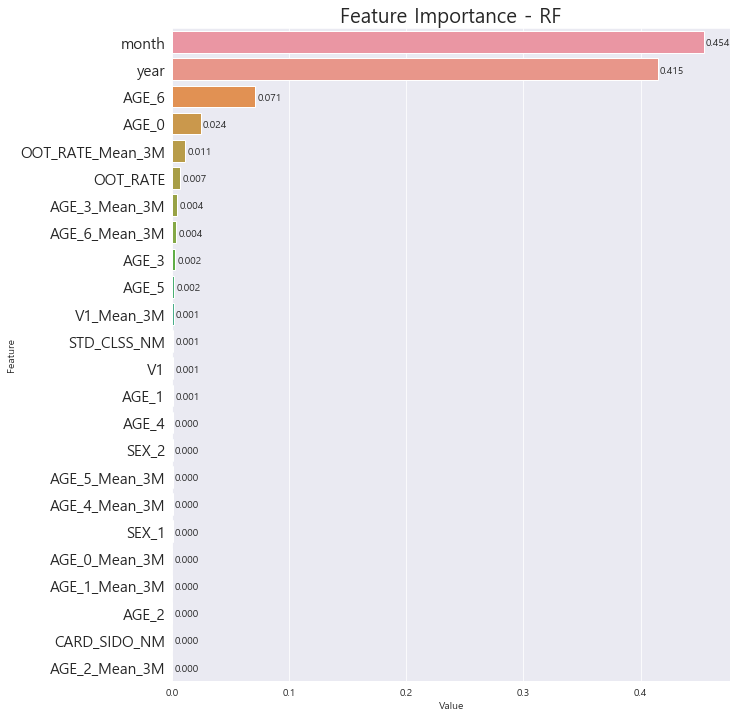

46

In [98]:
feature_imp = pd.DataFrame(sorted(zip(rf_model.feature_importances_,X.columns)), columns=['Value','Feature'])

fig, ax = plt.subplots(figsize=(10, 12))

sns.barplot(x="Value", y="Feature", data = feature_imp.sort_values(by = "Value", ascending = False))
ax.set_yticklabels(labels = feature_imp.sort_values(by = "Value", ascending = False).Feature,size = 15)

for p in ax.patches:
    importance = '{:.3f}'.format(p.get_width())
    x = p.get_x() + p.get_width() + 0.002
    y = p.get_y() + p.get_height()/1.5
    ax.annotate(importance, (x,y), size = 10)
    
plt.title("Feature Importance - RF", fontsize = 20)
plt.show()

gc.collect()

* CSTMR_CNT 변수를 넣었을 때 해당 변수의 importance가 너무 커 다른 변수들의 영향력이 너무 떨어짐
* 예측시기의 CSTMR_CNT를 알 수 없기 때문에 해당 변수의 영향력을 없애거나 최대한 줄여서 모델을 만들어야 할 것으로 보임  

In [96]:
# train_X.groupby(group_col[1:]).size().reset_index().\
#         loc[train_X.groupby(group_col[1:]).size().reset_index()[0] < 15, ["CARD_SIDO_NM", "STD_CLSS_NM"]].values

#### LightGBM

In [181]:
lgb_params = {
    'boosting_type' : 'gbdt',
    'objective' : 'rmse',
    'num_leaves' : 16,
    'learning_rate' : 0.05,
    'subsample' : 0.75,
    'random_state' : 42
}

In [182]:
lgb_train = lgb.Dataset(X, label=y)

In [183]:
lgb_model = lgb.train(lgb_params, lgb_train, num_boost_round=2000)

##### Feature Importance - LightGBM 

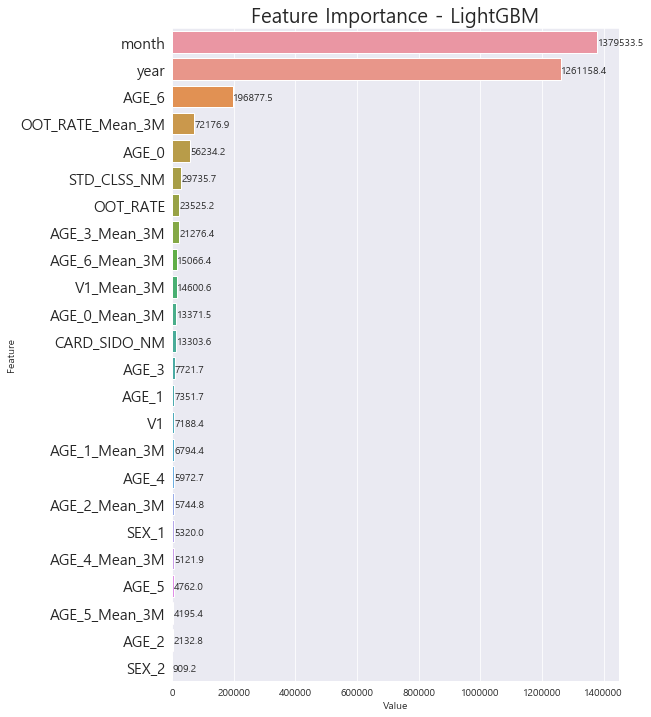

5805

In [235]:
feature_imp = pd.DataFrame(sorted(zip(lgb_model.feature_importance(importance_type = 'gain'),X.columns)), columns=['Value','Feature'])

fig, ax = plt.subplots(figsize=(8, 12))

sns.barplot(x="Value", y="Feature", data = feature_imp.sort_values(by = "Value", ascending = False))
ax.set_yticklabels(labels = feature_imp.sort_values(by = "Value", ascending = False).Feature,size = 15)

for p in ax.patches:
    importance = '{:.1f}'.format(p.get_width())
    x = p.get_x() + p.get_width() + 1000
    y = p.get_y() + p.get_height()/1.5
    ax.annotate(importance, (x,y), size = 10)
    
plt.title("Feature Importance - LightGBM", fontsize = 20)
plt.show()

gc.collect()

#### LSTM

In [19]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input, concatenate, RepeatVector, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.losses import MeanSquaredLogarithmicError

In [20]:
# Data for many-to-one lstm

def create_data(data, cat_cols = [],timestep = 14):
    main_input = []
    auxiliary_input = []
    y = []
    
    for sido, clss in data.loc[:, cat_cols].drop_duplicates(cat_cols, keep = 'first').values:
        df_train = data.loc[(data.CARD_SIDO_NM == sido) & (data.STD_CLSS_NM == clss),\
                                  [col for col in data.columns if col not in cat_cols]]

        if df_train.dtypes['REG_YYMM'] == '<M8[ns]':
            df_train = df_train.set_index('REG_YYMM')
        else:
            df_train['REG_YYMM'] = pd.to_datetime(df_train.REG_YYMM.apply(lambda x:str(x)), format="%Y%m")

        label = df_train.loc[:,'AMT'].iloc[timestep:].values
        df_train = df_train.iloc[:timestep,:].drop('AMT', axis=1).values    
        
        main_input.append(df_train)
        auxiliary_input.append([sido,clss])
        y.append(label)
        
    return np.array(main_input), np.array(auxiliary_input), np.array(y)

In [117]:
# Data for many-to-many lstm

def create_data_2(data, cat_cols=[], drop_cols=["CSTMR_CNT","CSTMR_CNT_Mean_3M"],
                  train_months=8, skip_months_bef=0, skip_months_aft=2, predicted_months=1, valid_ratio=0.1, train = True):
    
    # cat_cols : categorical성격의 column들
    # train_months : 학습시킬 시기 == timesteps
    # skip_months_bef : training 시작시기
    # skip_months_aft : training시기와 prediction시기 사이의 공백시기
    # predicted_months : 예측할 개월 수
    # valid_ratio : validation set 비율
    
    train_data = []
    valid_data = []
    auxiliary_data = []
    labels = []
    
    drop_cols = cat_cols + drop_cols
    

    sliced_months = sum([train_months,skip_months_aft,predicted_months])
    
    sliced_df_lst = []
    
    for i, (sido, clss) in enumerate(data.loc[:, cat_cols].drop_duplicates(cat_cols, keep = 'first').values):
        sliced_df = data.loc[(data.CARD_SIDO_NM == sido) & (data.STD_CLSS_NM == clss),[col for col in data.columns if col not in drop_cols]]
        sliced_df = sliced_df.iloc[skip_months_bef:(skip_months_bef+sliced_months), :].reset_index(drop = True)

        train_df = sliced_df.iloc[:train_months, :]
        
        if train_df.dtypes['REG_YYMM'] == '<M8[ns]':
            if i == 0:
                print(f' Train Start Time : {train_df.REG_YYMM.values[0]} \n Train Last Time : {train_df.REG_YYMM.values[-1]}')
            train_df = train_df.set_index('REG_YYMM')
            
                
        else:
            train_df['REG_YYMM'] = pd.to_datetime(train_df.REG_YYMM.apply(lambda x:str(x)), format="%Y%m")
            if i == 0:
                print(train_df['REG_YYMM'][0])
            train_df.set_index('REG_YYMM')
        
        if i == 0:
            print(f' Predicted Time : {sliced_df.REG_YYMM.values[-1]}')
        label = sliced_df.loc[:, 'AMT'].iloc[-predicted_months:].values
        
        sliced_df_lst.append(train_df.drop('AMT', axis=1).values)
        auxiliary_data.append([sido, clss])
        labels.append(label)
    
    if train == True:
        train_data, valid_data, train_label, valid_label, train_aux, valid_aux = train_test_split(sliced_df_lst, labels, auxiliary_data,test_size = valid_ratio, random_state = 42)
        
    test_df = pd.DataFrame(auxiliary_data, columns = ['CARD_SIDO_NM', 'STD_CLSS_NM'])
    test_df['REG_YYMM'] = sliced_df.REG_YYMM.values[-1]
    
    if train == True:
        return np.array(train_data), np.array(valid_data), np.array(train_label), np.array(valid_label), np.array(train_aux), np.array(valid_aux)
    elif train == False:
        return np.array(sliced_df_lst), np.array(labels), np.array(auxiliary_data), test_df

In [54]:
def get_lstm(timesteps, n_features):
    lstm_input = Input(shape = (timesteps, n_features), dtype = 'float32', name = "input")
    x = LSTM(16)(lstm_input)
    lstm_output = Dense(1)(x)
    return Model(lstm_input, lstm_output, name = 'simple_lstm')

In [23]:
def get_model(timesteps, n_features, n_aux_features):
    num_cells = 16
    
    input_1 = Input(shape = (timesteps, n_features), dtype = 'float32', name = "main_input")
    x = LSTM(num_cells, name = 'lstm')(input_1)
    
    input_2 = Input(shape = (n_aux_features,), dtype = 'float32', name = "aux_input")
    x_2 = Dense(2, name = 'dense_1')(input_2)
    
    x = concatenate([x, x_2], name = 'concatenate_1')
    x = Dense(16, activation='relu', name = 'dense_2')(x)
    x = Dense(4, activation = 'relu', name = 'dense_3')(x)
    
    output = Dense(1, name = 'dense_4')(x)
    
    return Model(inputs=[input_1, input_2],outputs=output)

In [24]:
if not os.path.exists(os.path.join(os.getcwd(), "tf_logs")):
    os.mkdir(os.path.join(os.getcwd(), "tf_logs"))

root_logdir = os.path.join(os.getcwd(), "tf_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [89]:
def get_callback(model_name=None, patient=10, es=False, rr=False, ts=True, mc=False ):
    ES = EarlyStopping(
        monitor='val_loss',  # Early Stopping을 어떤 수치를 보고 정할것인가
        patience=patient,  # 몇번 연속으로 val_loss가 개선되지 않았을때 Early Stopping 할 것인가
        mode='min',  # monitor하는 수치가 최소화되게? minimize objective function
        verbose=1  # 진행사항을 화면에 띄움
    )

    RR = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,  # learning rate를 줄이는 비율 / new_lr = lr * factor
        patience=10,
        min_lr=0.000001,  # learning_rate가 0.000001보다 작아지면 멈춤
        verbose=1,
        mode='min')
    
    run_logdir = get_run_logdir()
    TS = TensorBoard(run_logdir)  
    
    MC = ModelCheckpoint(
    filepath=model_name,  # model file을 저장할 path
    monitor='val_loss',
    verbose=1,
    save_best_only=True,  # 해당 epoch에서 가장 성능이 좋은 모델만 저장. 덮어쓰는 형식
    mode='min')
    
    callbacks_all = [ES, RR, TS, MC]
    callbacks = []
    
    for index in [n for n,val in enumerate([es, rr, ts, mc]) if val == True]:
        callbacks.append(callbacks_all[index])

    return callbacks

In [123]:
def rmsle(y, y_pred, mode = 'normal'):
    assert len(y) == len(y_pred)
    if mode == 'normal':
        terms_to_sum = [(np.log(y_pred[i] + 1) - np.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
        return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5
    elif mode == 'exp':
        y = np.exp(y)
        y_pred = np.exp(y_pred)
        terms_to_sum = [(np.log(y_pred[i] + 1) - np.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
        return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [27]:
main, sub = split_data(train_X)

In [28]:
train_lstm = main.drop(['year', 'month'], axis=1)

In [29]:
cstm_scaler = StandardScaler()
cstm_3m_scaler = StandardScaler()

In [30]:
train_lstm['CSTMR_CNT'] = cstm_scaler.fit_transform(train_lstm[['CSTMR_CNT']])
train_lstm['CSTMR_CNT_Mean_3M'] = cstm_3m_scaler.fit_transform(train_lstm[['CSTMR_CNT_Mean_3M']])

In [31]:
cat_cols = ['CARD_SIDO_NM', 'STD_CLSS_NM']

In [242]:
train_data, valid_data, train_label, valid_label, train_aux, valid_aux = create_data_2(train_lstm, cat_cols=cat_cols, train_months=12, skip_months_aft=0)

 Train Start Time : 2019-01-01T00:00:00.000000000 
 Train Last Time : 2019-12-01T00:00:00.000000000
 Predicted Time : 2020-01-01T00:00:00.000000000


In [238]:
train_data.shape, valid_data.shape

((537, 12, 20), (60, 12, 20))

In [239]:
timesteps, n_features = train_data.shape[1:]

In [243]:
lstm_model = get_lstm(timesteps, n_features)
lstm_model.compile(optimizer=Adam(learning_rate=0.002), loss = 'mse')

In [88]:
model_path = os.path.join(os.getcwd(), 'models')

if not os.path.exists(model_path):
    os.mkdir(model_path)

model_version = f'{lstm_model.name}.h5'
model_name = os.path.join(model_path, model_version)

In [244]:
hist = lstm_model.fit(
                train_data,
                train_label,
                validation_data=(valid_data, valid_label),
                batch_size=64,
                epochs=500,
                verbose=2,
                # callbacks = get_callback()
              )

Train on 537 samples, validate on 60 samples
Epoch 1/500
537/537 [==============================] - 2s 3ms/sample - loss: 417.7665 - val_loss: 379.5645
Epoch 2/500
537/537 [==============================] - 0s 139us/sample - loss: 391.7103 - val_loss: 356.0808
Epoch 3/500
537/537 [==============================] - 0s 124us/sample - loss: 367.6673 - val_loss: 331.6279
Epoch 4/500
537/537 [==============================] - 0s 147us/sample - loss: 340.6103 - val_loss: 303.6252
Epoch 5/500
537/537 [==============================] - 0s 124us/sample - loss: 312.2246 - val_loss: 277.7872
Epoch 6/500
537/537 [==============================] - 0s 124us/sample - loss: 286.7071 - val_loss: 254.7073
Epoch 7/500
537/537 [==============================] - 0s 124us/sample - loss: 264.2336 - val_loss: 235.3596
Epoch 8/500
537/537 [==============================] - 0s 109us/sample - loss: 245.4667 - val_loss: 219.1858
Epoch 9/500
537/537 [==============================] - 0s 108us/sample - loss: 229.60

Epoch 153/500
537/537 [==============================] - 0s 116us/sample - loss: 3.8233 - val_loss: 3.7799
Epoch 154/500
537/537 [==============================] - 0s 108us/sample - loss: 3.7681 - val_loss: 3.7237
Epoch 155/500
537/537 [==============================] - 0s 109us/sample - loss: 3.7731 - val_loss: 3.7196
Epoch 156/500
537/537 [==============================] - 0s 108us/sample - loss: 3.7614 - val_loss: 3.7326
Epoch 157/500
537/537 [==============================] - 0s 109us/sample - loss: 3.7617 - val_loss: 3.7378
Epoch 158/500
537/537 [==============================] - 0s 101us/sample - loss: 3.7433 - val_loss: 3.7451
Epoch 159/500
537/537 [==============================] - 0s 117us/sample - loss: 3.7029 - val_loss: 3.6615
Epoch 160/500
537/537 [==============================] - 0s 115us/sample - loss: 3.6992 - val_loss: 3.7413
Epoch 161/500
537/537 [==============================] - 0s 108us/sample - loss: 3.6430 - val_loss: 3.6600
Epoch 162/500
537/537 [==============

537/537 [==============================] - 0s 108us/sample - loss: 2.2251 - val_loss: 3.3735
Epoch 306/500
537/537 [==============================] - 0s 117us/sample - loss: 2.2724 - val_loss: 3.2942
Epoch 307/500
537/537 [==============================] - 0s 117us/sample - loss: 2.2157 - val_loss: 3.2821
Epoch 308/500
537/537 [==============================] - 0s 108us/sample - loss: 2.1763 - val_loss: 3.4190
Epoch 309/500
537/537 [==============================] - 0s 109us/sample - loss: 2.1747 - val_loss: 3.2834
Epoch 310/500
537/537 [==============================] - 0s 108us/sample - loss: 2.1762 - val_loss: 3.4109
Epoch 311/500
537/537 [==============================] - 0s 109us/sample - loss: 2.1358 - val_loss: 3.3190
Epoch 312/500
537/537 [==============================] - 0s 108us/sample - loss: 2.1534 - val_loss: 3.2956
Epoch 313/500
537/537 [==============================] - 0s 102us/sample - loss: 2.1560 - val_loss: 3.7110
Epoch 314/500
537/537 [============================

537/537 [==============================] - 0s 100us/sample - loss: 1.2576 - val_loss: 2.9308
Epoch 458/500
537/537 [==============================] - 0s 109us/sample - loss: 1.2591 - val_loss: 2.7725
Epoch 459/500
537/537 [==============================] - 0s 100us/sample - loss: 1.2705 - val_loss: 2.7191
Epoch 460/500
537/537 [==============================] - 0s 101us/sample - loss: 1.2747 - val_loss: 2.6962
Epoch 461/500
537/537 [==============================] - 0s 116us/sample - loss: 1.2840 - val_loss: 2.9620
Epoch 462/500
537/537 [==============================] - 0s 109us/sample - loss: 1.3299 - val_loss: 2.8011
Epoch 463/500
537/537 [==============================] - 0s 108us/sample - loss: 1.3320 - val_loss: 2.8117
Epoch 464/500
537/537 [==============================] - 0s 109us/sample - loss: 1.3286 - val_loss: 2.4676
Epoch 465/500
537/537 [==============================] - 0s 117us/sample - loss: 1.2615 - val_loss: 2.6989
Epoch 466/500
537/537 [============================

In [245]:
test_data,test_label,test_aux,test_df = create_data_2(train_lstm, skip_months_bef=1, train_months=12,skip_months_aft=0, cat_cols = cat_cols,train=False)

 Train Start Time : 2019-02-01T00:00:00.000000000 
 Train Last Time : 2020-01-01T00:00:00.000000000
 Predicted Time : 2020-02-01T00:00:00.000000000


In [260]:
test_df['pred_AMT'] = lstm_model.predict(test_data)

In [248]:
test_df.merge(train_lstm.loc[:, group_col + ['AMT']], how = 'left')

,CARD_SIDO_NM,STD_CLSS_NM,REG_YYMM,pred_AMT,AMT
0,0,0,2020-02-01,19.708563,18.152874
1,0,1,2020-02-01,22.824924,20.691214
2,0,2,2020-02-01,22.270082,20.580797
3,0,3,2020-02-01,16.504089,16.611297
4,0,5,2020-02-01,15.506156,15.437884
...,...,...,...,...,...
592,16,36,2020-02-01,21.511829,20.899221
593,16,37,2020-02-01,23.514500,23.576217
594,16,38,2020-02-01,17.966070,16.259329
595,16,39,2020-02-01,20.800646,20.020094


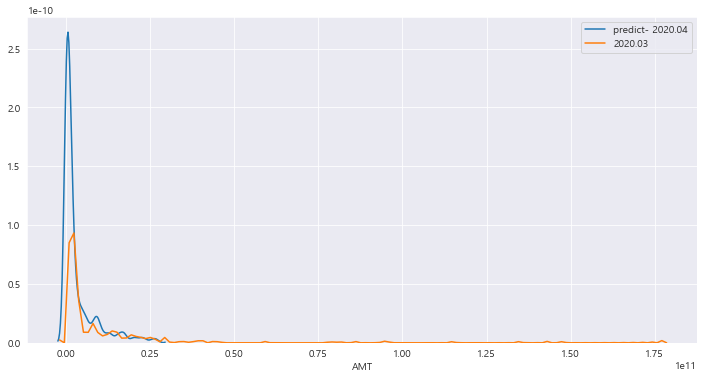

In [91]:
plt.figure(figsize = (12,6))
sns.distplot(np.exp(lstm_model.predict(test_data)), hist = False, label = 'predict- 2020.04')
sns.distplot(np.exp(train_X.loc[train_X.REG_YYMM == train_X.REG_YYMM.max(), 'AMT']), hist = False, label = '2020.03')

In [49]:
train_X.loc[train_X.REG_YYMM == train_X.REG_YYMM.max(), 'AMT']

14      18.380473
29      21.793409
44      20.718069
59      16.404574
75      14.545472
          ...    
9377    20.997289
9392    23.505340
9407    16.539995
9422    19.876691
9437    16.359746
Name: AMT, Length: 609, dtype: float64

In [44]:
np.exp(train_X.AMT.min())

16499.999999999985

In [264]:
rmsle(test_label, lstm_model.predict(test_data), mode = 'exp')

array([1.62110955])

In [253]:
lstm_with_aux = get_model(timesteps= timesteps, n_features= n_features, n_aux_features=2)

In [254]:
lstm_with_aux.compile(loss = 'mse', optimizer= Adam(learning_rate=0.002))

In [255]:
lstm_with_aux.fit(
    x = [train_data, train_aux],
    y = train_label,
    validation_data=([valid_data, valid_aux], valid_label),
    epochs=500,
    batch_size=64,
    verbose = 2,
    callbacks = get_callback(patient=30, es = False, rr = True, ts = False)
)

Train on 537 samples, validate on 60 samples
Epoch 1/500
537/537 [==============================] - 2s 3ms/sample - loss: 430.9437 - val_loss: 402.8942
Epoch 2/500
537/537 [==============================] - 0s 148us/sample - loss: 421.9134 - val_loss: 393.4443
Epoch 3/500
537/537 [==============================] - 0s 124us/sample - loss: 410.0516 - val_loss: 380.2644
Epoch 4/500
537/537 [==============================] - 0s 124us/sample - loss: 394.4101 - val_loss: 363.7033
Epoch 5/500
537/537 [==============================] - 0s 131us/sample - loss: 375.4277 - val_loss: 343.9687
Epoch 6/500
537/537 [==============================] - 0s 124us/sample - loss: 352.4196 - val_loss: 319.4290
Epoch 7/500
537/537 [==============================] - 0s 124us/sample - loss: 324.3627 - val_loss: 289.2566
Epoch 8/500
537/537 [==============================] - 0s 117us/sample - loss: 289.7508 - val_loss: 253.7126
Epoch 9/500
537/537 [==============================] - 0s 124us/sample - loss: 249.82

Epoch 77/500
537/537 [==============================] - 0s 108us/sample - loss: 2.9183 - val_loss: 3.2608
Epoch 78/500
537/537 [==============================] - 0s 117us/sample - loss: 2.8475 - val_loss: 3.1494
Epoch 79/500
537/537 [==============================] - 0s 117us/sample - loss: 2.7971 - val_loss: 3.2238
Epoch 80/500
537/537 [==============================] - 0s 124us/sample - loss: 2.8008 - val_loss: 3.3166
Epoch 81/500
537/537 [==============================] - 0s 124us/sample - loss: 2.6924 - val_loss: 3.0031
Epoch 82/500
537/537 [==============================] - 0s 108us/sample - loss: 2.6904 - val_loss: 2.8466
Epoch 83/500
537/537 [==============================] - 0s 117us/sample - loss: 2.6776 - val_loss: 3.0941
Epoch 84/500
537/537 [==============================] - 0s 109us/sample - loss: 2.6410 - val_loss: 3.0696
Epoch 85/500
537/537 [==============================] - 0s 123us/sample - loss: 2.5244 - val_loss: 3.2110
Epoch 86/500
537/537 [========================

537/537 [==============================] - 0s 108us/sample - loss: 1.5828 - val_loss: 2.5545
Epoch 216/500
537/537 [==============================] - 0s 110us/sample - loss: 1.5828 - val_loss: 2.5545
Epoch 217/500
537/537 [==============================] - 0s 115us/sample - loss: 1.5828 - val_loss: 2.5544
Epoch 218/500
537/537 [==============================] - 0s 109us/sample - loss: 1.5828 - val_loss: 2.5545
Epoch 219/500
537/537 [==============================] - 0s 116us/sample - loss: 1.5828 - val_loss: 2.5544
Epoch 220/500
537/537 [==============================] - 0s 108us/sample - loss: 1.5828 - val_loss: 2.5544
Epoch 221/500
537/537 [==============================] - 0s 124us/sample - loss: 1.5828 - val_loss: 2.5544
Epoch 222/500
537/537 [==============================] - 0s 124us/sample - loss: 1.5828 - val_loss: 2.5545
Epoch 223/500
537/537 [==============================] - 0s 117us/sample - loss: 1.5828 - val_loss: 2.5547
Epoch 224/500
537/537 [============================

537/537 [==============================] - 0s 117us/sample - loss: 1.5823 - val_loss: 2.5571
Epoch 368/500
537/537 [==============================] - 0s 131us/sample - loss: 1.5822 - val_loss: 2.5571
Epoch 369/500
537/537 [==============================] - 0s 124us/sample - loss: 1.5822 - val_loss: 2.5570
Epoch 370/500
537/537 [==============================] - 0s 102us/sample - loss: 1.5822 - val_loss: 2.5571
Epoch 371/500
537/537 [==============================] - 0s 117us/sample - loss: 1.5822 - val_loss: 2.5573
Epoch 372/500
537/537 [==============================] - 0s 122us/sample - loss: 1.5823 - val_loss: 2.5575
Epoch 373/500
537/537 [==============================] - 0s 117us/sample - loss: 1.5822 - val_loss: 2.5576
Epoch 374/500
537/537 [==============================] - 0s 117us/sample - loss: 1.5822 - val_loss: 2.5576
Epoch 375/500
537/537 [==============================] - 0s 117us/sample - loss: 1.5822 - val_loss: 2.5576
Epoch 376/500
537/537 [============================

In [258]:
test_df['pred_AMT_2'] = lstm_with_aux.predict([test_data, test_aux])

In [263]:
test_df['AMT'] = test_label

In [264]:
test_df

,CARD_SIDO_NM,STD_CLSS_NM,REG_YYMM,pred_AMT,pred_AMT_2,AMT
0,0,0,2020-02-01,19.708563,19.332222,18.152874
1,0,1,2020-02-01,22.824924,21.004732,20.691214
2,0,2,2020-02-01,22.270082,21.411699,20.580797
3,0,3,2020-02-01,16.504089,16.610270,16.611297
4,0,5,2020-02-01,15.506156,15.892408,15.437884
...,...,...,...,...,...,...
592,16,36,2020-02-01,21.511829,21.876965,20.899221
593,16,37,2020-02-01,23.514500,22.998686,23.576217
594,16,38,2020-02-01,17.966070,21.312628,16.259329
595,16,39,2020-02-01,20.800646,20.845591,20.020094


In [267]:
rmsle(test_label, test_df.pred_AMT), rmsle(test_label, test_df.pred_AMT_2)

(array([0.07105195]), array([0.0757923]))

1049

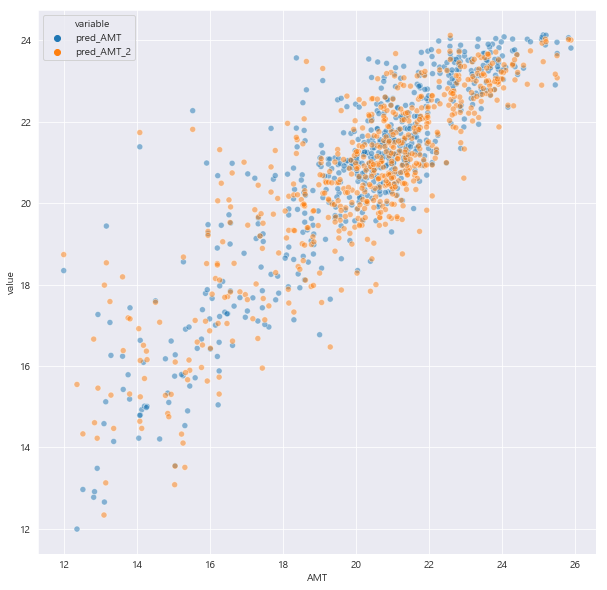

In [265]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = test_df.melt(id_vars = group_col[1:] + ['AMT','REG_YYMM']),
                x = 'AMT', y='value', hue = 'variable', alpha = 0.5)

gc.collect()

### Submission 

In [50]:
sub2 = tmp_test[['CARD_SIDO_NM','STD_CLSS_NM']]
# sub2['AMT'] = lgb_model.predict(tmp_test)
sub2['AMT'] = rf_model.predict(tmp_test)

# sub2.loc[sub2.CARD_SIDO_NM == 14, 'AMT'] = sub2.loc[sub2.CARD_SIDO_NM == 14, 'AMT'] * (1/jeju_weight)
sub2['AMT'] = np.exp(sub2['AMT'])

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished
c:\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [51]:
sub2['CARD_SIDO_NM'] = le_CARD_SIDO_NM.inverse_transform(sub2.CARD_SIDO_NM)
sub2['STD_CLSS_NM'] = le_STD_CLSS_NM.inverse_transform(sub2.STD_CLSS_NM)

c:\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [52]:
subm = sub.drop('AMT', axis=1).merge(sub2, how = 'left').sort_values(by = 'id')

In [53]:
subm = subm.fillna(0)

* 15개월간 data가 모두 존재하는 경우만 예측을 한 상태
* 1~14개월간의 data가 존재하는 경우에 대하여 결과를 넣으면 score가 더 나아짐

In [54]:
model = 'rf'
version = 0.1

In [55]:
file_name = os.path.join(os.curdir,'result',f'sub_{model}_{version}.csv')

In [56]:
subm.to_csv(file_name, index = False, encoding='utf-8-sig')

### EDA - model feedback

In [217]:
res = tmp_test.iloc[:, :2]

In [218]:
res['rf_AMT'] = rf_model.predict(tmp_test)
res['lgb_AMT'] = lgb_model.predict(tmp_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


In [219]:
res = res.merge(train_X.loc[(train_X.year == 2020) & (train_X.month == 2), group_col[1:] + ['AMT']].reset_index(drop = True), how='left')

In [228]:
test_df.merge(train_lstm.loc[:, group_col + ['AMT']], how = 'left').merge(res)

,CARD_SIDO_NM,STD_CLSS_NM,REG_YYMM,pred_AMT,AMT,rf_AMT,lgb_AMT
0,0,0,2020-02-01,19.488596,18.152874,18.360653,18.509624
1,0,1,2020-02-01,22.779026,20.691214,21.863392,21.348678
2,0,2,2020-02-01,21.999256,20.580797,20.869740,20.558501
3,0,3,2020-02-01,16.927979,16.611297,19.121391,17.146262
4,0,5,2020-02-01,16.608646,15.437884,15.864149,15.339293
...,...,...,...,...,...,...,...
592,16,36,2020-02-01,21.290718,20.899221,20.818494,20.742279
593,16,37,2020-02-01,23.309446,23.576217,23.104402,23.668844
594,16,38,2020-02-01,17.290367,16.259329,18.939200,17.593803
595,16,39,2020-02-01,20.527065,20.020094,20.639271,19.979695


In [7]:
"""plt.figure(figsize = (10,10))
sns.scatterplot(data = test_df.merge(train_lstm.loc[:, group_col + ['AMT']], how = 'left').merge(res).melt(id_vars = group_col[1:] + ['AMT','REG_YYMM']),
                x = 'AMT', y='value', hue = 'variable', alpha = 0.5)

gc.collect()"""

"plt.figure(figsize = (10,10))\nsns.scatterplot(data = test_df.merge(train_lstm.loc[:, group_col + ['AMT']], how = 'left').merge(res).melt(id_vars = group_col[1:] + ['AMT','REG_YYMM']),\n                x = 'AMT', y='value', hue = 'variable', alpha = 0.5)\n\ngc.collect()"

In [8]:
"""plt.figure(figsize = (10,10))
sns.scatterplot(data = res.melt(id_vars = group_col[1:] + ['AMT']), x = 'AMT', y='value', hue = 'variable', alpha = 0.5)

gc.collect()"""

"plt.figure(figsize = (10,10))\nsns.scatterplot(data = res.melt(id_vars = group_col[1:] + ['AMT']), x = 'AMT', y='value', hue = 'variable', alpha = 0.5)\n\ngc.collect()"

In [268]:
nfull_df

,CARD_SIDO_NM,STD_CLSS_NM,REG_YYMM,year,month,CSTMR_CNT,V1,AGE_0,AGE_1,AGE_2,...,V1_Mean_3M,AGE_0_Mean_3M,AGE_1_Mean_3M,AGE_2_Mean_3M,AGE_3_Mean_3M,AGE_4_Mean_3M,AGE_5_Mean_3M,AGE_6_Mean_3M,OOT_RATE_Mean_3M,AMT
0,0,4,2019-05-01,2019,5,6,0.600000,0.0,0.0,0.000,...,0.792102,0.0,0.169474,0.125611,0.288447,0.311251,0.088688,0.016529,0.015873,12.083905
1,0,14,2019-01-01,2019,1,41,0.744372,0.0,0.0,0.000,...,0.748124,0.0,0.000000,0.000000,0.691057,0.146341,0.162602,0.000000,1.000000,15.068562
2,0,14,2019-04-01,2019,4,3,0.750000,0.0,0.0,0.000,...,0.748124,0.0,0.000000,0.000000,0.691057,0.146341,0.162602,0.000000,1.000000,11.641582
3,0,14,2019-07-01,2019,7,6,0.750000,0.0,0.0,0.000,...,0.748124,0.0,0.000000,0.000000,0.691057,0.146341,0.162602,0.000000,1.000000,12.974072
4,0,14,2020-01-01,2020,1,14,0.916667,0.0,0.0,0.000,...,0.805556,0.0,0.000000,0.000000,0.738095,0.119048,0.142857,0.000000,1.000000,13.345523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,16,28,2019-09-01,2019,9,3,1.000000,0.0,0.0,0.000,...,0.938889,0.0,0.296296,0.000000,0.000000,0.444444,0.259259,0.000000,0.111111,10.971641
479,16,28,2019-10-01,2019,10,4,1.000000,0.0,0.0,0.000,...,0.966667,0.0,0.111111,0.000000,0.000000,0.777778,0.111111,0.000000,0.111111,13.122363
480,16,28,2019-11-01,2019,11,10,0.916667,0.0,0.7,0.000,...,0.972222,0.0,0.233333,0.000000,0.000000,0.766667,0.000000,0.000000,0.111111,13.850878
481,16,28,2019-12-01,2019,12,8,0.916667,0.0,0.0,0.375,...,0.944444,0.0,0.233333,0.125000,0.000000,0.641667,0.000000,0.000000,0.277778,13.873779
